In [1]:
import sympy as sp
import jax.numpy as np
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
from eq1 import config
from main import run

In [3]:
network, best, loss_histories = run(config)

16:25:12.604 [INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
16:25:12.605 [INFO] Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
16:25:12.606 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
16:25:12.868 [INFO] Constructed symbolic model
16:25:13.760 [INFO] Constructed loss equation
16:25:13.318 [INFO] Constructed JAXified model
16:25:15.811 [INFO] Epoch: 1, Loss: 18.06186294555664
16:25:15.843 [INFO] Epoch: 2, Loss: 6.456302165985107
16:25:15.882 [INFO] Epoch: 3, Loss: 16.912567138671875
16:25:15.936 [INFO] Epoch: 4, Loss: 6.093877792358398
16:25:15.969 [INFO] Epoch: 5, Loss: 2.367640733718872
16:25:15.998 [INFO] Epoch: 6, Loss: 1.198925495147705
16:25:16.260 [INFO] Epoch: 7, Loss: 0.6371877193450928
16:25:16.530 [INFO] Epoch: 8, Loss: 1.1922056674957275
16:25:16.800 [INFO] Epoch: 9, 

Nothing more to prune!


$\displaystyle 0.392628759145737 r t + 0.598986446857452 e^{1.17462992668152 r t} + 0.396474972367287$

In [4]:
network.model_y

a_o1__02__03 + a_o4__00__03*r*t + a_o5__01__03*exp(a_o4__00__01*r*t) + b

In [5]:
y_prediction_best = best.model_y.subs(zip(best.alphas, best.W))
y_prediction_best

0.392628759145737*r*t + 0.598986446857452*exp(1.17462992668152*r*t) + 0.396474972367287

# Plot

In [6]:
r = network.symbols.r
t = network.symbols.t

In [7]:
y_pred_fn = sp.lambdify([r, t], y_prediction_best)
y_real_fn = sp.lambdify([r, t], sp.exp(r*t))

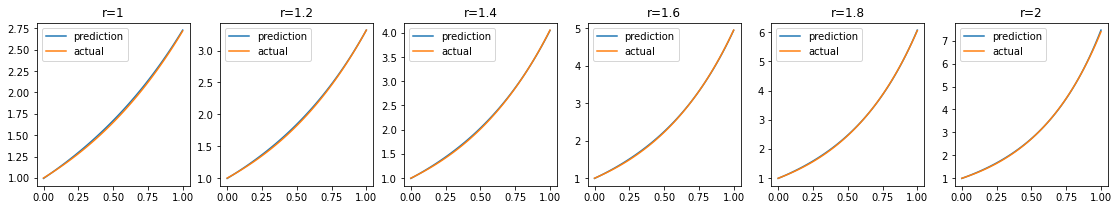

In [8]:
t_try = np.linspace(0, 1, 50)

r_tries = [1, 1.2, 1.4, 1.6, 1.8, 2]
fig, axs = plt.subplots(1, len(r_tries))
fig.set_size_inches(len(r_tries)*3.2, 3)

for ax, r_try in zip(axs, r_tries):
  ax.set_title(f'r={r_try}')
  ax.plot(t_try, y_pred_fn(r_try, t_try), label=f'prediction')
  ax.plot(t_try, y_real_fn(r_try, t_try), label=f'actual')
  ax.legend()
plt.show()

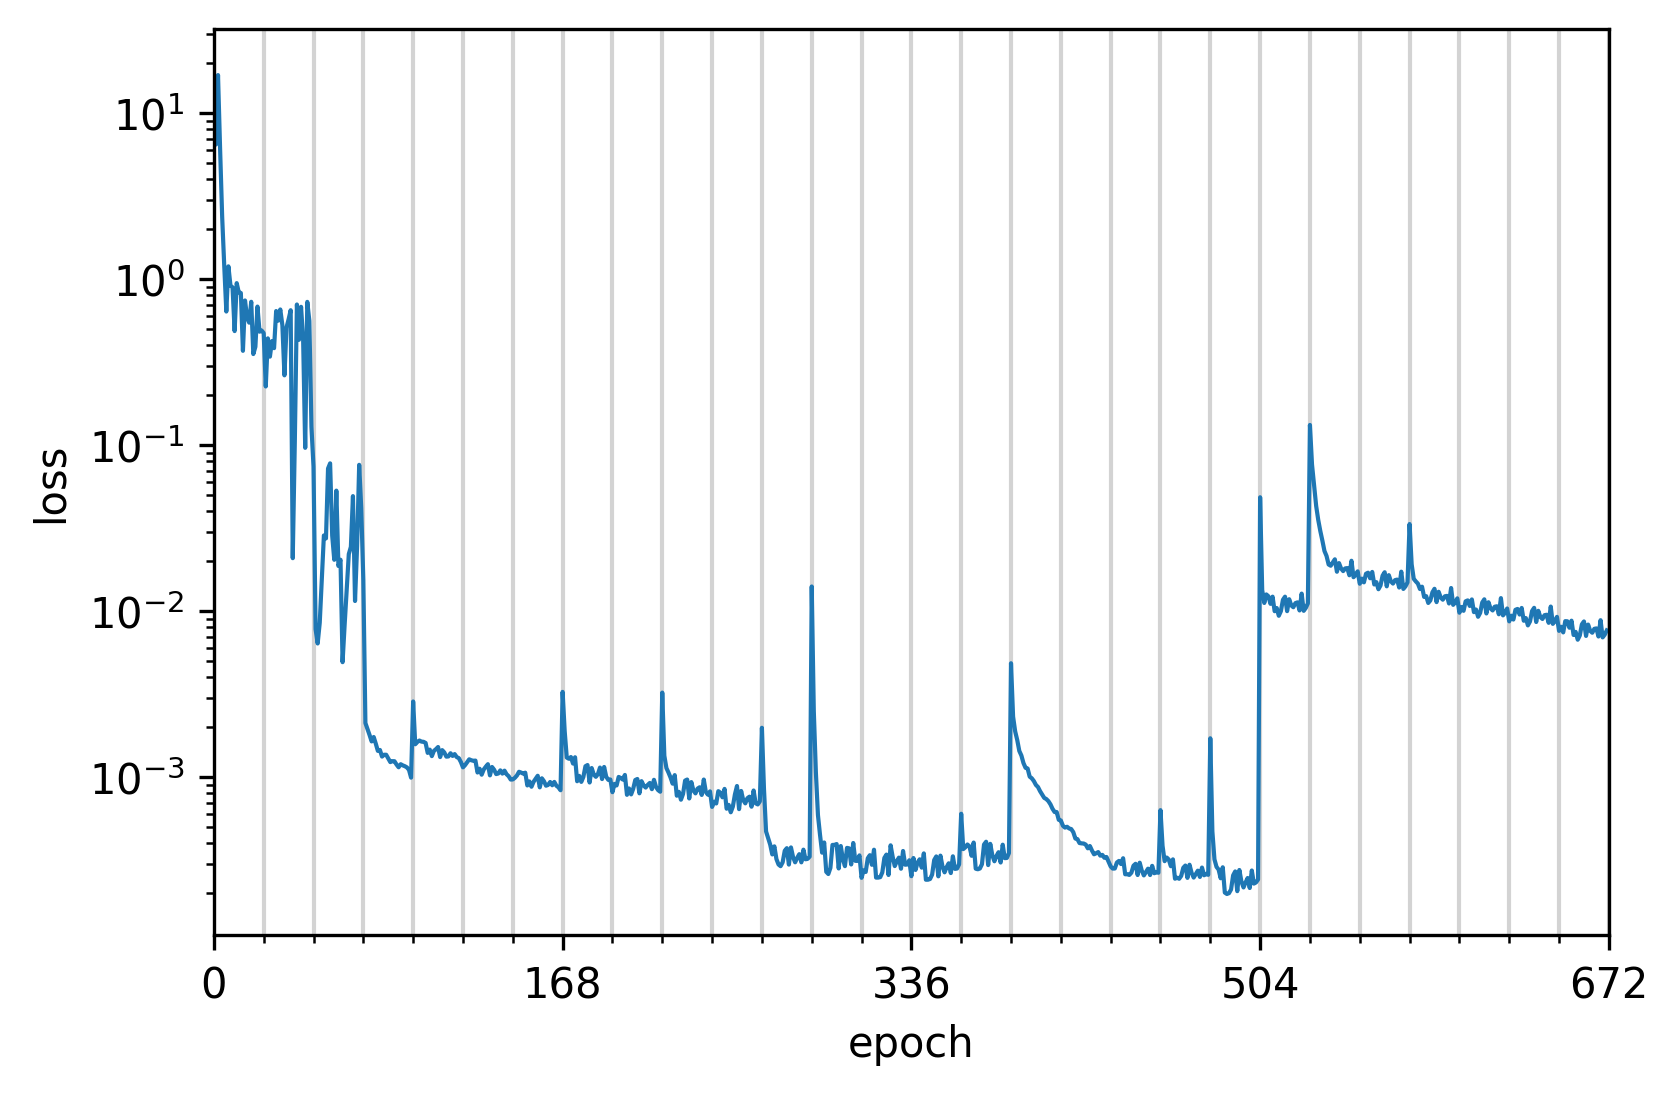

In [25]:
from itertools import chain

loss_history = []
prunepoints = []

for pruneepoch in loss_histories:
  count = 0 if len(prunepoints) == 0 else prunepoints[len(prunepoints)-1]
  for epoch in pruneepoch:
    loss_history += [np.average(np.array(epoch))]
    count += 1
  prunepoints += [count]

plt.xlabel('epoch')
plt.xlim((0, prunepoints[len(prunepoints) - 1]))
plt.gcf().gca().xaxis.set_major_locator(plt.MultipleLocator(168))
plt.gcf().gca().xaxis.set_minor_locator(plt.MultipleLocator(24))
plt.yscale('log')
plt.ylabel('loss')
for prunepoint in prunepoints:
  plt.axvline(prunepoint, color='lightgrey', linewidth=1)
plt.plot(loss_history, linewidth=1)
plt.gcf().set_dpi(300)
plt.show()

# Test

In [12]:
dPdt = sp.diff(y_prediction_best, 't')

loss = (dPdt - network.symbols.r * y_prediction_best)**2

sp.integrate(loss, ('t', 0, 1), ('r', 1, 2))

0.00742749961916075

In [13]:
P = sp.exp(r*t)

dPdt = sp.diff(P, t)

loss = (dPdt - r * P)**2

sp.integrate(loss, ('t', 0, 1), ('r', 1, 2))

0